### Demonstration of the LsstCameraFootprint ###

The `LsstCameraFootprint` is a class that reads a pre-calculated footprint map for the LSST camera field of view (which includes chip gaps) and then when provided with a list of either pointings of interest, or one object pointing but several boresight pointings, returns the indexes of the points which landed on silicon. 

The footprint map is derived from the LSST DM camera model in `obs_lsst`. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from rubin_scheduler.data import get_data_dir
from rubin_scheduler.utils import LsstCameraFootprint, _angular_separation

In [3]:
# The pointing location is somewhat irrelevant for what is used here, 
# but choosing one relatively 'overhead' seems safest. 
# The rotation angle DOES matter as it will rotate the camera on the sky. 
pointing_ra = np.radians(15)
pointing_dec = np.radians(-20)
pointing_rot = np.radians(0)

In [4]:
# The "units" describe whether the boresight and test points are in 'radians' or 'degrees'
# The "footprint_file" describes where to find the fov map. 
# This can be in RUBIN_SIM_DATA_DIR/tests or RUBIN_SIM_DATA_DIR/maf.

camera = LsstCameraFootprint(units='radians')

In [5]:
# What happens if we pass one point, near the center of the fov?
# we should find that this point is visible.
eps = 0.00001
camera([pointing_ra+eps], [pointing_dec], pointing_ra, pointing_dec, 0)

array([0])

In [6]:
# What happens if we pass one point, far from the center of the fov?
# we should find that this point is not visible.
eps = np.radians(2)
camera([pointing_ra+eps], [pointing_dec], pointing_ra, pointing_dec, 0)

array([], dtype=int64)

Text(0, 0.5, 'Dec (radians)')

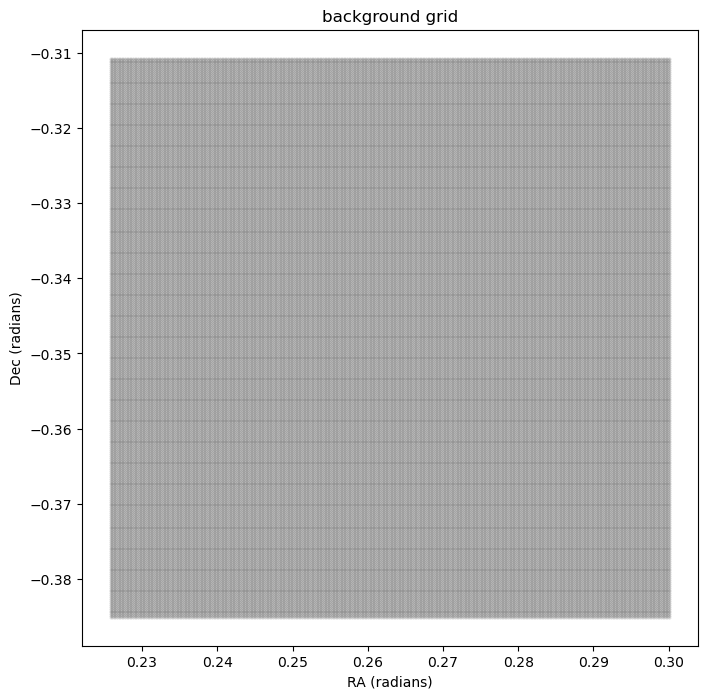

In [7]:
# Okay, let's set up a grid across and slightly beyond a whole FOV

radius = np.radians(2.2)
stepsize = np.radians(0.005)
ra = np.arange(pointing_ra - radius*np.cos(pointing_dec), pointing_ra + radius, stepsize*np.cos(pointing_dec))
dec = np.arange(pointing_dec - radius*np.cos(pointing_dec), pointing_dec + radius, stepsize)
ra, dec = np.meshgrid(ra, dec)
ra = ra.flatten()
dec = dec.flatten()


m=0.05  # set markersize 
plt.figure(figsize=(8,8))
plt.plot(ra, dec, 'k.', markersize=m)
plt.title('background grid')
plt.axis('square')
plt.xlabel('RA (radians)')
plt.ylabel('Dec (radians)')
# Uncomment to zoom in very tightly - unevenness in plot is due to sampling in plot
#plt.xlim(0.25, 0.26)
#plt.ylim(-0.36, -0.35)

In [8]:
# Find which points fall onto the camera
idx = camera(ra, dec, pointing_ra, pointing_dec, pointing_rot)
idx

array([ 67751,  67752,  67753, ..., 686557, 686558, 686559])

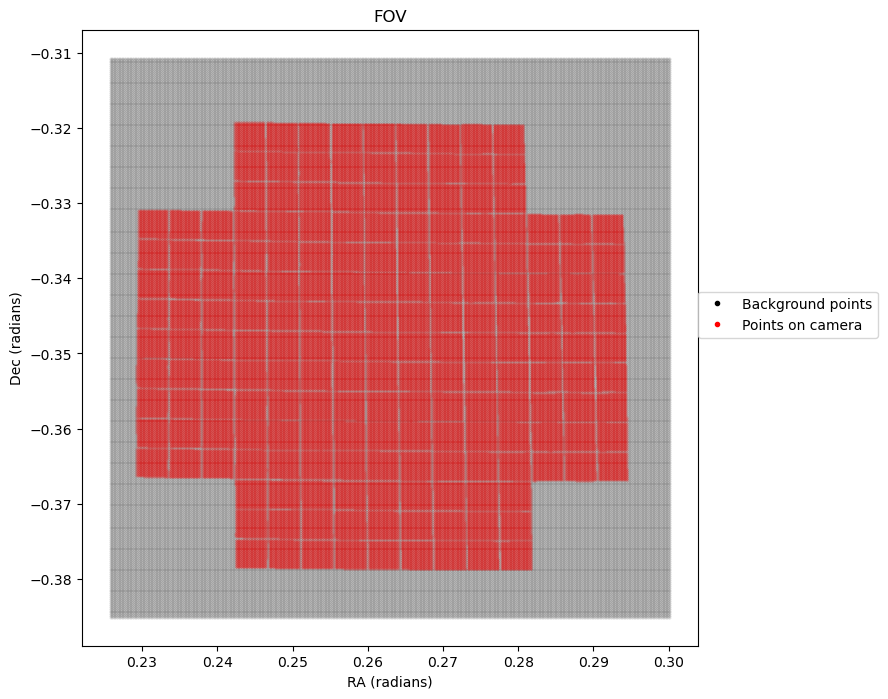

In [9]:
plt.figure(figsize=(8,8))
plt.plot(ra, dec, 'k.', markersize=m)
plt.plot(ra[idx], dec[idx], 'r.', markersize=m*2)
plt.title('FOV')
plt.axis('square')
plt.xlabel('RA (radians)')
plt.ylabel('Dec (radians)')
plt.plot(1.0, 0.5, 'k.', label='Background points')
plt.plot(1.0, 0.4, 'r.', label='Points on camera')
plt.legend(loc=(1.0, 0.5))
# Uncomment to zoom in very tightly - unevenness in plot is due to sampling in plot
#plt.xlim(0.25, 0.26)
#plt.ylim(-0.36, -0.35)

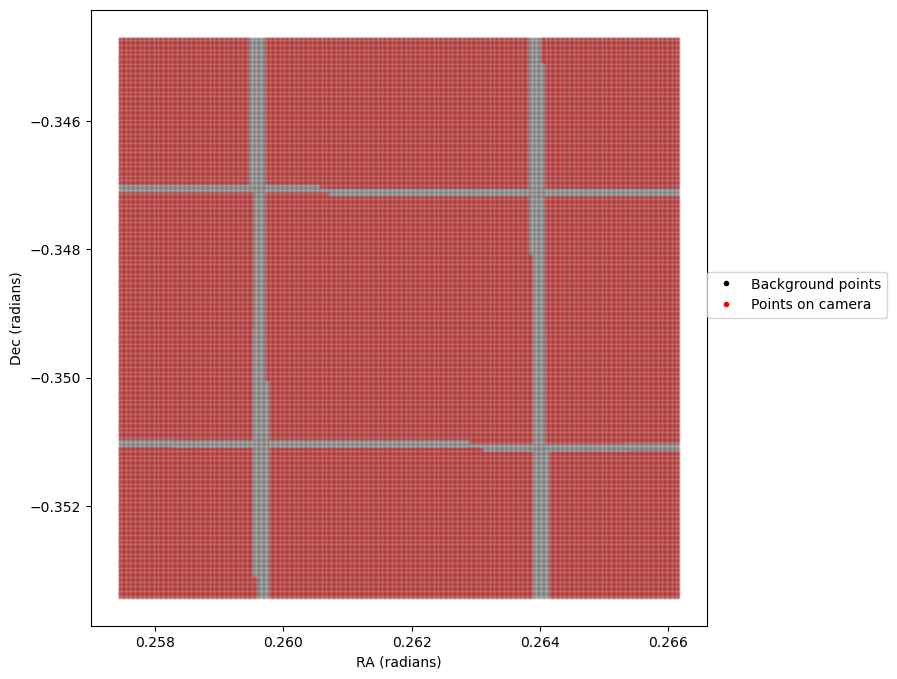

In [10]:
# zoom in .. 
radius = np.radians(.25)
stepsize = np.radians(0.0005)
ra = np.arange(pointing_ra - radius, pointing_ra + radius, stepsize)
dec = np.arange(pointing_dec - radius, pointing_dec + radius, stepsize)
ra, dec = np.meshgrid(ra, dec)
ra = ra.flatten()
dec = dec.flatten()
idx = camera(ra, dec, pointing_ra, pointing_dec, pointing_rot)

plt.figure(figsize=(8,8))
plt.plot(ra, dec, 'k.', markersize=m)
plt.plot(ra[idx], dec[idx], 'r.', markersize=m)
plt.axis('square')
plt.xlabel('RA (radians)')
plt.ylabel('Dec (radians)')
plt.plot(1.0, 0.5, 'k.', label='Background points')
plt.plot(1.0, 0.4, 'r.', label='Points on camera')
plt.legend(loc=(1.0, 0.5))

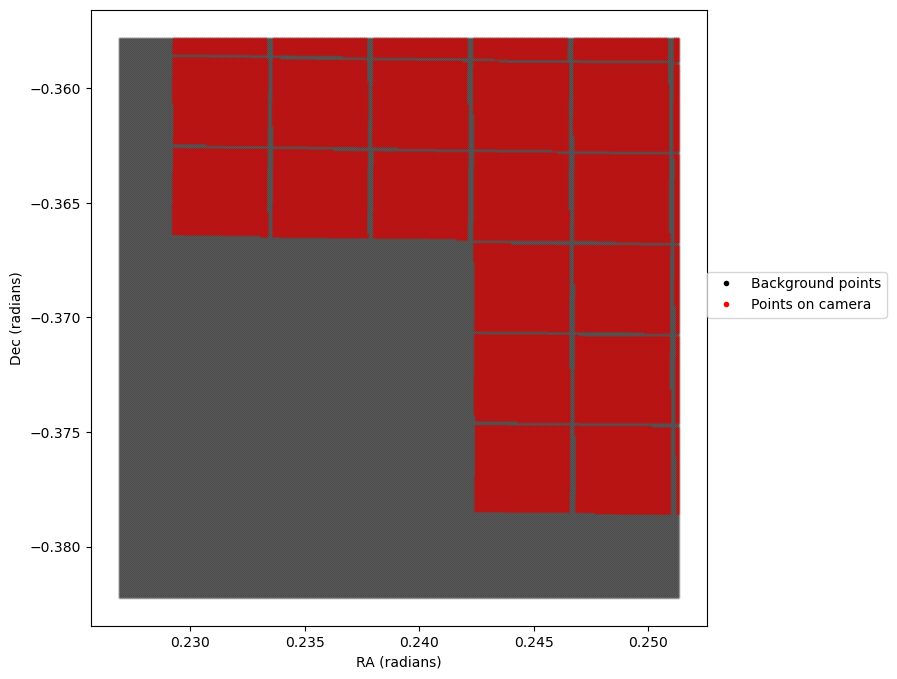

In [11]:
radius = np.radians(0.7)
stepsize = np.radians(0.001)
offset_ra = np.radians(1.3)
offset_dec = np.radians(1.2)
ra = np.arange(pointing_ra - radius - offset_ra, pointing_ra + radius - offset_ra, stepsize)
dec = np.arange(pointing_dec - radius - offset_dec, pointing_dec + radius - offset_dec, stepsize)
ra, dec = np.meshgrid(ra, dec)
ra = ra.flatten()
dec = dec.flatten()
idx = camera(ra, dec, pointing_ra, pointing_dec, pointing_rot)

plt.figure(figsize=(8,8))
plt.plot(ra, dec, 'k.', markersize=m)
plt.plot(ra[idx], dec[idx], 'r.', markersize=m)
plt.axis('square')
plt.xlabel('RA (radians)')
plt.ylabel('Dec (radians)')
plt.plot(1.0, 0.5, 'k.', label='Background points')
plt.plot(1.0, 0.4, 'r.', label='Points on camera')
plt.legend(loc=(1.0, 0.5))

In [12]:
# Recreate plot from IAU-318 proceedings (with fill factor)

radius = np.radians(2.2)
stepsize = np.radians(0.005)
xcen = 0
ycen = 0

x = np.arange(xcen - radius, xcen + radius, stepsize)
y = np.arange(ycen - radius, ycen + radius, stepsize)
x, y = np.meshgrid(x, y)
x = x.flatten()
y = y.flatten()

idx = camera(x, y, xcen, ycen, 0)

In [13]:
# Calculate % fill factor, for a particular assumed (circular) fov
area_degsq = 9.6
innerradius = np.sqrt(area_degsq/np.pi)
print('inner radius matching area_degsq for circle', innerradius)
sep = np.degrees(_angular_separation(x, y, xcen, ycen))
#print('max distance from center used for chip calculation', sep.max())
incircle = np.where(sep < innerradius)[0]
onchip = np.sort(np.array(list(set(incircle).intersection(set(idx)))))
fillfactor = len(onchip) / float(len(incircle))
print('fill factor', fillfactor)

area_degsq = 9.6
innerradius2 = 1.75
print('inner radius matching area_degsq for circle', innerradius2)
sep = np.degrees(_angular_separation(x, y, xcen, ycen))
#print('max distance from center used for chip calculation', sep.max())
incircle = np.where(sep < innerradius2)[0]
onchip = np.sort(np.array(list(set(incircle).intersection(set(idx)))))
fillfactor = len(onchip) / float(len(incircle))
print('fill factor', fillfactor)

outerradius = 2.06
print('outer radius', outerradius)
sep = np.degrees(_angular_separation(x, y, xcen, ycen))
#print('max distance from center used for chip calculation', sep.max())
incircle = np.where(sep < outerradius)[0]
onchip = np.sort(np.array(list(set(incircle).intersection(set(idx)))))
fillfactor = len(onchip) / float(len(incircle))
print('fill factor', fillfactor)

inner radius matching area_degsq for circle 1.7480774889473265
fill factor 0.8819111899237826
inner radius matching area_degsq for circle 1.75
fill factor 0.8814646938505002
outer radius 2.06
fill factor 0.6882077939612834


Text(0.78, 0.55, ' r=2.06$^\\circ$')

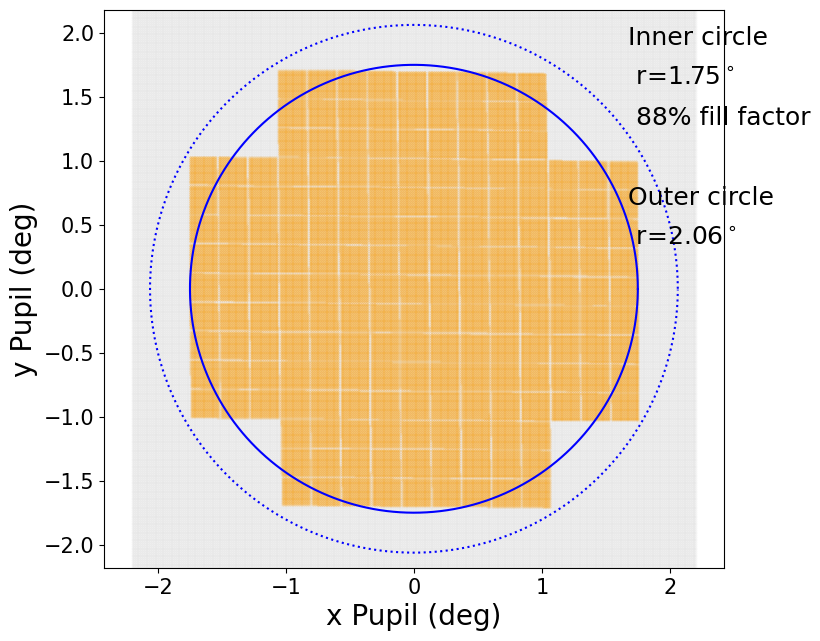

In [14]:
plt.figure(figsize=(8,8))
plt.plot(np.degrees(x), np.degrees(y),
         linestyle='', color='lightgray', marker='.', markersize=m)
plt.plot(np.degrees(x[idx]), np.degrees(y[idx]), 
         linestyle='', color='orange', marker='.', markersize=m*2)
plt.axis('square')
# RA/Dec could be replaced with x Pupil / y Pupil or vice versa
plt.xlabel('x Pupil (deg)', fontsize=20)
plt.yticks(fontsize=15)
plt.ylabel('y Pupil (deg)', fontsize=20)
plt.xticks(fontsize=15)
theta = np.arange(0, 2*np.pi, 0.01)
plt.plot(innerradius*np.cos(theta)+np.degrees(xcen), innerradius*np.sin(theta)+np.degrees(ycen), 'b-')
plt.plot(outerradius*np.cos(theta)+np.degrees(ycen), outerradius*np.sin(theta)+np.degrees(xcen), 'b:')
plt.ylim(np.degrees(xcen)-sep.max()*.7, np.degrees(ycen)+sep.max()*.7)
xco = 0.78
plt.figtext(xco, 0.8, 'Inner circle', fontsize=18)
plt.figtext(xco, 0.75, r' r=1.75$^\circ$', fontsize=18)
plt.figtext(xco, 0.7, ' 88%s fill factor' %('%'), fontsize=18)
plt.figtext(xco, 0.6, 'Outer circle', fontsize=18)
plt.figtext(xco, 0.55, r' r=2.06$^\circ$', fontsize=18)